In [1]:
import jax
from jax import custom_jvp, pure_callback, vmap, grad, jit
from jax.lax import scan

import jax.numpy as jnp
from jax.scipy.special import bessel_jn

import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.special import jv

from jax.config import config
config.update("jax_enable_x64", True) # this is *absolutely essential* for the jax bessel function to be numerically stable


In [2]:
RP1 = jnp.array([
-8.99971225705559398224E8, 4.52228297998194034323E11,
-7.27494245221818276015E13, 3.68295732863852883286E15,])
RQ1 = jnp.array([
 1.0, 6.20836478118054335476E2, 2.56987256757748830383E5, 8.35146791431949253037E7, 
 2.21511595479792499675E10, 4.74914122079991414898E12, 7.84369607876235854894E14, 
 8.95222336184627338078E16, 5.32278620332680085395E18,])

PP1 = jnp.array([
 7.62125616208173112003E-4, 7.31397056940917570436E-2, 1.12719608129684925192E0, 
 5.11207951146807644818E0, 8.42404590141772420927E0, 5.21451598682361504063E0, 1.00000000000000000254E0,])
PQ1 = jnp.array([
 5.71323128072548699714E-4, 6.88455908754495404082E-2, 1.10514232634061696926E0, 
 5.07386386128601488557E0, 8.39985554327604159757E0, 5.20982848682361821619E0, 9.99999999999999997461E-1,])

QP1 = jnp.array([
 5.10862594750176621635E-2, 4.98213872951233449420E0, 7.58238284132545283818E1, 
 3.66779609360150777800E2, 7.10856304998926107277E2, 5.97489612400613639965E2, 2.11688757100572135698E2, 2.52070205858023719784E1,])
QQ1  = jnp.array([
 1.0, 7.42373277035675149943E1, 1.05644886038262816351E3, 4.98641058337653607651E3, 
 9.56231892404756170795E3, 7.99704160447350683650E3, 2.82619278517639096600E3, 3.36093607810698293419E2,])

YP1 = jnp.array([
 1.26320474790178026440E9,-6.47355876379160291031E11, 1.14509511541823727583E14,
 -8.12770255501325109621E15, 2.02439475713594898196E17,-7.78877196265950026825E17,])
YQ1 = jnp.array([
 5.94301592346128195359E2, 2.35564092943068577943E5, 7.34811944459721705660E7, 
 1.87601316108706159478E10, 3.88231277496238566008E12, 6.20557727146953693363E14, 
 6.87141087355300489866E16, 3.97270608116560655612E18,])

Z1 = 1.46819706421238932572E1
Z2 = 4.92184563216946036703E1
PIO4 = .78539816339744830962 # pi/4
THPIO4 = 2.35619449019234492885 # 3*pi/4
SQ2OPI = .79788456080286535588 # sqrt(2/pi)

def j1_small(x):
    z = x * x
    w = jnp.polyval(RP1, z) / jnp.polyval(RQ1, z)
    w = w * x * (z - Z1) * (z - Z2)
    return w

def j1_large_c(x):    
    w = 5.0 / x
    z = w * w
    p = jnp.polyval(PP1, z) / jnp.polyval(PQ1, z)
    q = jnp.polyval(QP1, z) / jnp.polyval(QQ1, z)
    xn = x - THPIO4
    p = p * jnp.cos(xn) - w * q * jnp.sin(xn)
    return p * SQ2OPI / jnp.sqrt(x)

def j1(x):
    """
    Bessel function of order one - using the implementation from CEPHES, translated to Jax.
    """
    return jnp.sign(x)*jnp.where(jnp.abs(x) < 5.0, j1_small(jnp.abs(x)),j1_large_c(jnp.abs(x)))

In [3]:
f = jit((j1))
gs  = jit(vmap(grad(j1)))


In [4]:
x = np.linspace(0,10,1000)

In [5]:
%timeit f(x).block_until_ready()
%timeit gs(x).block_until_ready()
grad(j1)(1.e-4) # test good gradients for small values

103 µs ± 32.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
153 µs ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Array(0.5, dtype=float64, weak_type=True)

(-50.0, 50.0)

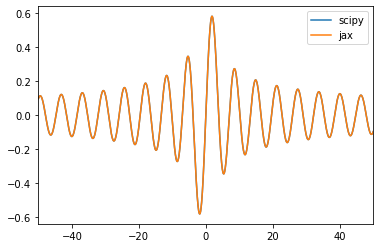

In [6]:
x = np.linspace(-50, 50, 10000)

y = jv(1, x)
yy = j1(x)
# yy_large = j1_large(x)
# yy_small = j1_small(x)
# yy_c = j1_c(x)

plt.plot(x, y, label="scipy")
plt.plot(x, yy, label="jax")
# plt.plot(x, yy_large, label="jax large")
# plt.plot(x, yy_c, label="jax c")

plt.legend()
plt.xlim(-50,50)


(-50.0, 50.0)

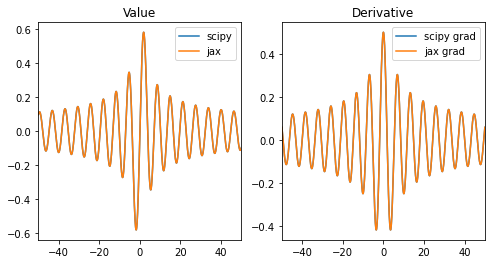

In [7]:
## do the plot of the value and the derivative, in subplots (1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4),sharex=True)

ax1.plot(x, y, label="scipy")
ax1.plot(x, yy, label="jax")
ax1.legend()
ax1.set_title('Value')

gscipy = 0.5 * (jv(0, x) - jv(2, x))
gg = gs(x)
ax2.plot(x, gscipy, label="scipy grad")
ax2.plot(x, gg, label="jax grad")
ax2.legend()
ax2.set_title("Derivative")
ax1.set_xlim(-50, 50)

(-50.0, 50.0)

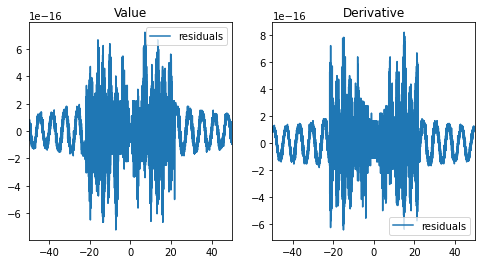

In [8]:
## do the plot of the value and the derivative, in subplots (1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4),sharex=True)

ax1.plot(x, y-yy, label="residuals")
ax1.legend()
ax1.set_title('Value')

ax2.plot(x, gg-gscipy, label="residuals")
ax2.legend()
ax2.set_title("Derivative")
ax1.set_xlim(-50, 50)

In [9]:
(np.all(np.isfinite(gg)),np.all(np.isfinite(yy)))

(True, True)

# Now do the same for J0

In [10]:

PP0 = jnp.array([
  7.96936729297347051624E-4,
  8.28352392107440799803E-2,
  1.23953371646414299388E0,
  5.44725003058768775090E0,
  8.74716500199817011941E0,
  5.30324038235394892183E0,
  9.99999999999999997821E-1,
])
PQ0 = jnp.array([
  9.24408810558863637013E-4,
  8.56288474354474431428E-2,
  1.25352743901058953537E0,
  5.47097740330417105182E0,
  8.76190883237069594232E0,
  5.30605288235394617618E0,
  1.00000000000000000218E0,
])

QP0 = jnp.array([
-1.13663838898469149931E-2,
-1.28252718670509318512E0,
-1.95539544257735972385E1,
-9.32060152123768231369E1,
-1.77681167980488050595E2,
-1.47077505154951170175E2,
-5.14105326766599330220E1,
-6.05014350600728481186E0,
])
QQ0 = jnp.array([1.0,
  6.43178256118178023184E1,
  8.56430025976980587198E2,
  3.88240183605401609683E3,
  7.24046774195652478189E3,
  5.93072701187316984827E3,
  2.06209331660327847417E3,
  2.42005740240291393179E2,
])

YP0 = jnp.array([
 1.55924367855235737965E4,
-1.46639295903971606143E7,
 5.43526477051876500413E9,
-9.82136065717911466409E11,
 8.75906394395366999549E13,
-3.46628303384729719441E15,
 4.42733268572569800351E16,
-1.84950800436986690637E16,
])
YQ0 = jnp.array([
 1.04128353664259848412E3,
 6.26107330137134956842E5,
 2.68919633393814121987E8,
 8.64002487103935000337E10,
 2.02979612750105546709E13,
 3.17157752842975028269E15,
 2.50596256172653059228E17,
])

DR10 = 5.78318596294678452118E0
DR20 = 3.04712623436620863991E1

RP0 = jnp.array([
-4.79443220978201773821E9,
 1.95617491946556577543E12,
-2.49248344360967716204E14,
 9.70862251047306323952E15,
])
RQ0 = jnp.array([ 1.0,
 4.99563147152651017219E2,
 1.73785401676374683123E5,
 4.84409658339962045305E7,
 1.11855537045356834862E10,
 2.11277520115489217587E12,
 3.10518229857422583814E14,
 3.18121955943204943306E16,
 1.71086294081043136091E18,
])

In [11]:
def j0_small(x):
    '''
    Implementation of J0 for x < 5 
    '''
    z = x * x
    # if x < 1.0e-5:
    #     return 1.0 - z/4.0

    p = (z - DR10) * (z - DR20)
    p = p * jnp.polyval(RP0,z)/jnp.polyval(RQ0, z)
    return jnp.where(x<1e-5,1-z/4.0,p)
    

def j0_large(x):
    '''
    Implementation of J0 for x >= 5
    '''

    w = 5.0/x
    q = 25.0/(x*x)
    p = jnp.polyval(PP0, q)/jnp.polyval(PQ0, q)
    q = jnp.polyval(QP0, q)/jnp.polyval(QQ0, q)
    xn = x - PIO4
    p = p * jnp.cos(xn) - w * q * jnp.sin(xn)
    return p * SQ2OPI / jnp.sqrt(x)

def j0(x):
    '''
    Implementation of J0 for all x in Jax
    '''

    return jnp.where(jnp.abs(x) < 5.0, j0_small(jnp.abs(x)),j0_large(jnp.abs(x)))
    

(-50.0, 50.0)

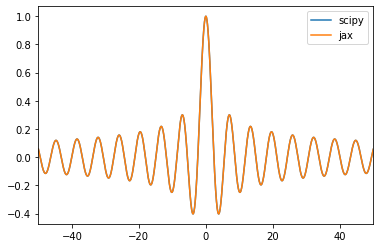

In [12]:
x = np.linspace(-50, 50, 10000)

y0 = jv(0, x)
yy0 = j0(x)
# yy_large = j1_large(x)
# yy_small = j1_small(x)
# yy_c = j1_c(x)

plt.plot(x, y0, label="scipy")
plt.plot(x, yy0, label="jax")
# plt.plot(x, yy_large, label="jax large")
# plt.plot(x, yy_c, label="jax c")

plt.legend()
plt.xlim(-50,50)


In [13]:
f0 = jit((j0))
gs0  = jit(vmap(grad(j0)))


In [14]:
%timeit f0(x).block_until_ready()
%timeit gs0(x).block_until_ready()
grad(j0)(1.e-4) # test good gradients for small values

141 µs ± 53.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
645 µs ± 108 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Array(-4.99999999e-05, dtype=float64, weak_type=True)

(-50.0, 50.0)

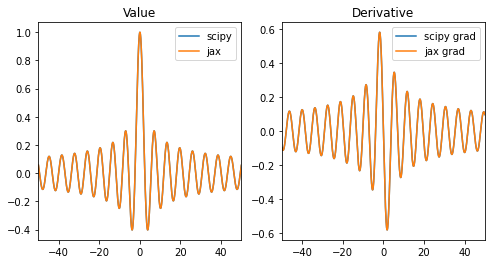

In [15]:
## do the plot of the value and the derivative, in subplots (1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4),sharex=True)

ax1.plot(x, y0, label="scipy")
ax1.plot(x, yy0, label="jax")
ax1.legend()
ax1.set_title('Value')

gscipy0 = -jv(1, x)
gg0 = gs0(x)
ax2.plot(x, gscipy0, label="scipy grad")
ax2.plot(x, gg0, label="jax grad")

ax2.legend()
ax2.set_title("Derivative")
ax1.set_xlim(-50, 50)

(-50.0, 50.0)

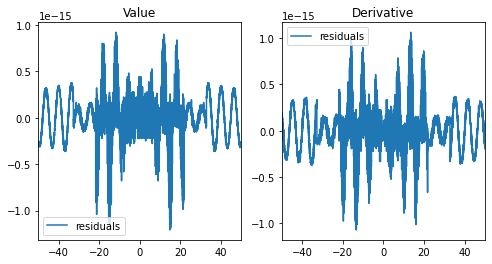

In [16]:
## do the plot of the value and the derivative, in subplots (1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4),sharex=True)

ax1.plot(x, y0-yy0, label="residuals")
ax1.legend()
ax1.set_title('Value')

ax2.plot(x, gg0-gscipy0, label="residuals")
ax2.legend()
ax2.set_title("Derivative")
ax1.set_xlim(-50, 50)

Perfect!

In [17]:
def jjv(n, x):
    """Compute the Bessel function J_n(x), for n >= 0"""
    # use recurrence relations
    def body(carry, i):
        jnm1, jn = carry
        jnplus = (2*i)/x * jn - jnm1
        return (jn, jnplus), jnplus
    _, jn = scan(body, (j0(x), j1(x)), jnp.arange(1,n))
    return jn[-1]

Text(0, 0.5, 'Values')

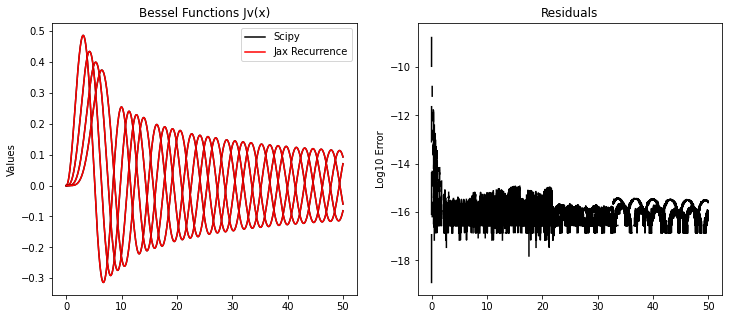

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5),sharex=True)

x = np.linspace(0.001,50,10000)
for nu in [2,3,4,5]:
    ynu = jv(nu, x)
    yynu = jjv(nu, x)

    ax1.plot(x,ynu,label='Scipy',color='k')
    ax1.plot(x,yynu,label='Jax Recurrence',color='r')
    if nu == 2:
        ax1.legend()

    ax2.plot(x,jnp.log10(ynu-yynu),color='k')

ax2.set_title('Residuals')
ax2.set_ylabel('Log10 Error')

ax1.set_title('Bessel Functions Jv(x)')
ax1.set_ylabel('Values')


In [19]:
np.all(np.isfinite(yynu))

True

In [20]:
recur = jit(jjv,static_argnums=0)

In [22]:
%timeit recur(3,x).block_until_ready()
%timeit recur(4,x).block_until_ready()
%timeit recur(5,x).block_until_ready()
%timeit recur(6,x).block_until_ready()

311 µs ± 38.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
314 µs ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
338 µs ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
383 µs ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
